In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
train_raw = pd.read_csv('../data/train_raw.csv')
train_raw

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
103901,103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


In [14]:
train_raw.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [15]:
print(train_raw['satisfaction'].value_counts())
# "만족", "중립 및 불만족" 두 개로 이진 분류 되어 있음
# "중립 및 불만족"을 불만족으로 간주해야할지 고민 필요
# 따라서 "중립 및 불만족"은 단순히 "만족하지 않음" 으로 간주하고 0, "만족"은 1로 변환
train_raw['satisfaction_binary'] = (
    train_raw['satisfaction'] == 'satisfied'
).astype(int)
train_raw[['satisfaction', 'satisfaction_binary']].head()

satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64


,satisfaction,satisfaction_binary
0,neutral or dissatisfied,0
1,neutral or dissatisfied,0
2,satisfied,1
3,neutral or dissatisfied,0
4,satisfied,1


In [16]:
# 모든 서비스 변수
service_cols = [
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness'
]

# 모든 서비스 변수의 unique 값과 0의 개수 확인
for col in service_cols:
    print(f"{col}: {train_raw[col].unique()}")  
    print(f" - 0의 개수: {sum(train_raw[col] == 0)}")

Inflight wifi service: [3 2 4 1 5 0]
 - 0의 개수: 3103
Departure/Arrival time convenient: [4 2 5 3 1 0]
 - 0의 개수: 5300
Ease of Online booking: [3 2 5 4 1 0]
 - 0의 개수: 4487
Gate location: [1 3 2 5 4 0]
 - 0의 개수: 1
Food and drink: [5 1 2 4 3 0]
 - 0의 개수: 107
Online boarding: [3 5 2 1 4 0]
 - 0의 개수: 2428
Seat comfort: [5 1 2 3 4 0]
 - 0의 개수: 1
Inflight entertainment: [5 1 2 3 4 0]
 - 0의 개수: 14
On-board service: [4 1 2 3 5 0]
 - 0의 개수: 3
Leg room service: [3 5 4 2 1 0]
 - 0의 개수: 472
Baggage handling: [4 3 5 1 2]
 - 0의 개수: 0
Checkin service: [4 1 3 5 2 0]
 - 0의 개수: 1
Inflight service: [5 4 3 1 2 0]
 - 0의 개수: 3
Cleanliness: [5 1 2 3 4 0]
 - 0의 개수: 12


0을 결측치로 볼지, 평가 점수로 볼지 고민해볼 필요가 있음.
일단 두 가지 경우의 상관계수를 계산

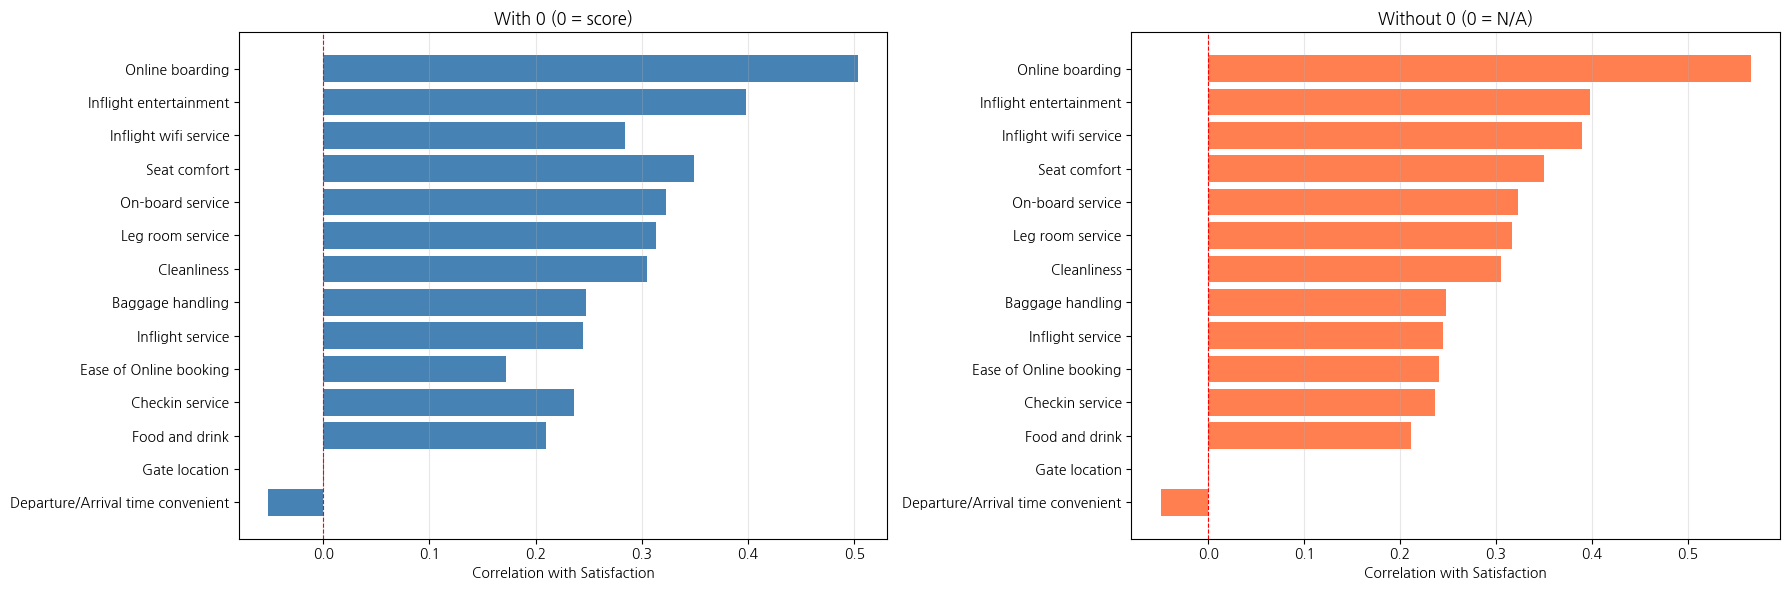


=== 0 포함 vs 0 제외 비교 ===
Service                                      With 0  Without 0 Difference
---------------------------------------------------------------------------
Departure/Arrival time convenient            -0.052     -0.049      0.002
Gate location                                 0.001      0.001      0.000
Food and drink                                0.210      0.211      0.001
Checkin service                               0.236      0.236     -0.000
Ease of Online booking                        0.172      0.241      0.069
Inflight service                              0.245      0.245     -0.000
Baggage handling                              0.248      0.248      0.000
Cleanliness                                   0.305      0.305     -0.000
Leg room service                              0.313      0.317      0.003
On-board service                              0.322      0.322     -0.000
Seat comfort                                  0.349      0.349     -0.000
Inflight wi

In [17]:
# 원본 데이터 백업 (0 포함)
train_with_zero = train_raw.copy()

# 0을 NaN으로 변환한 데이터
train_without_zero = train_raw.copy()
for col in service_cols:
    train_without_zero[col] = train_without_zero[col].replace(0, np.nan)

# 두 가지 경우의 상관계수 계산
correlations_with_zero = {}
correlations_without_zero = {}

for col in service_cols:
    # 0 포함
    corr_with = train_with_zero[[col, 'satisfaction_binary']].corr().iloc[0,1]
    correlations_with_zero[col] = corr_with
    
    # 0 제외
    corr_without = train_without_zero[[col, 'satisfaction_binary']].corr().iloc[0,1]
    correlations_without_zero[col] = corr_without

# 정렬 (0 제외 기준)
sorted_services = sorted(correlations_without_zero.items(), key=lambda x: x[1], reverse=False)
services = [x[0] for x in sorted_services]

corrs_with = [correlations_with_zero[s] for s in services]
corrs_without = [correlations_without_zero[s] for s in services]

# Subplot 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# 왼쪽: 0 포함
ax1.barh(services, corrs_with, color='steelblue')
ax1.set_xlabel('Correlation with Satisfaction')
ax1.set_title('With 0 (0 = score)')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=0.8)
ax1.grid(axis='x', alpha=0.3)

# 오른쪽: 0 제외
ax2.barh(services, corrs_without, color='coral')
ax2.set_xlabel('Correlation with Satisfaction')
ax2.set_title('Without 0 (0 = N/A)')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# 차이 출력
print("\n=== 0 포함 vs 0 제외 비교 ===")
print(f"{'Service':<40s} {'With 0':>10s} {'Without 0':>10s} {'Difference':>10s}")
print("-" * 75)
for service in services:
    with_val = correlations_with_zero[service]
    without_val = correlations_without_zero[service]
    diff = without_val - with_val
    print(f"{service:<40s} {with_val:>10.3f} {without_val:>10.3f} {diff:>10.3f}")

## 의미 해석

### 1. 디지털 서비스가 압도적 1위
**Online boarding (0.565):**
- 공항에서 줄 서지 않고 바로 탑승
- 모바일로 미리 처리하는 편리함
- 시간 절약 = 만족도 직결
- **현대 승객에게 디지털 경험이 물리적 서비스보다 중요**
- 0 제외 시 상관계수가 0.504→0.565로 급증 (차이 +0.062)
  - 이용하지 않은 승객을 제외하면 영향력이 더 명확히 드러남

### 2. 기내 경험 서비스 (2-4위)
**Inflight entertainment (0.398), Inflight wifi (0.390), Seat comfort (0.349):**
- 비행 중 내내 경험하는 서비스들
- 1-10시간 동안 지속적으로 노출
- **장시간 노출 = 큰 영향**
- Inflight wifi는 0 제외 시 0.284→0.390으로 대폭 상승 (+0.106)
  - Wi-Fi를 실제 사용한 승객에게는 매우 중요한 요소
  - 사용하지 않은 승객(0점)을 제외하면 진짜 중요도가 드러남

### 3. 디지털 서비스는 0 처리 방식에 민감
**0 제외 시 상관계수 변화:**
- Online boarding: +0.062
- Inflight wifi service: +0.106 (가장 큰 변화)
- Ease of Online booking: +0.069
- **해석:** 디지털 서비스는 "이용 안 함(0)" vs "이용함(1-5)" 차이가 크므로, 0을 점수로 포함하면 영향력이 과소평가됨

### 4. 물리적 서비스는 0 처리 무관
**0 포함/제외 시 거의 동일:**
- Seat comfort: 0.349 (변화 없음)
- Entertainment: 0.398 (변화 없음)
- Cleanliness: 0.305 (변화 없음)
- **해석:** 모든 승객이 경험하는 서비스라 0(결측)이 거의 없음

### 5. 예상과 다른 점
**Gate location (0.001):**
- 탑승구 위치는 만족도와 무관
- 공항 인프라는 통제 불가능하므로 승객이 기대하지 않음

**Departure/Arrival time convenient (-0.049):**
- 약한 음의 상관관계
- 예약 시 이미 선택한 요소이므로 불만 적음
- 또는 편리한 시간대 = 비싼 가격 = 높은 기대치 = 상대적 불만 가능성

### 6. 중간 그룹 서비스 (0.24-0.32)
**On-board service, Leg room, Cleanliness, Baggage handling:**
- 중요하지만 결정적이지는 않음
- 기본은 갖춰야 하는 수준
- 차별화 요소보다는 "당연히 제공되어야 할 서비스"

---

## 핵심 인사이트

### 1. 디지털 편의성 > 물리적 편안함
**Online boarding > Seat comfort**
- 현대 승객은 공항 경험의 효율성을 기내 편안함보다 우선시
- 디지털 전환의 중요성 입증

### 2. 데이터 전처리 방법의 중요성: 0을 어떻게 처리할 것인가?

**0 = 결측치(N/A)로 처리 결정:**
- 데이터 문서에 명시된 대로 모든 서비스에서 0을 결측치로 처리
- 특히 선택적 서비스(디지털)에서 효과가 크게 나타남

**선택적 서비스 (0 처리 효과 큼):**
- Inflight wifi: 0.284 → 0.390 (+0.106)
- Online boarding: 0.504 → 0.565 (+0.062)
- Ease of Online booking: 0.172 → 0.241 (+0.069)
- 이용하지 않은 승객(0)을 제외해야 실제 중요도 파악 가능
- **실무 시사점:** 디지털 서비스 투자 결정 시 "실제 이용자"의 평가를 기준으로 해야 함

**필수 서비스 (0 처리 효과 없음):**
- Seat comfort: 0.349 (변화 없음, 0이 1개)
- Entertainment: 0.398 (변화 없음, 0이 14개)
- Cleanliness: 0.305 (변화 없음, 0이 12개)
- 모든 승객이 경험하므로 0이 거의 없어 처리 방식이 결과에 영향 없음

**결론:**
- **본 분석에서는 모든 서비스에서 0을 결측치로 처리**
- 선택적 이용 서비스(디지털)는 이 처리로 인해 실제 중요도가 더 명확히 드러남
- 필수 경험 서비스(물리적)는 0이 거의 없어 처리 방식과 무관
- **방법론적 교훈:** 결측치 처리 방식이 서비스 유형에 따라 다른 영향을 미치므로, 0 포함/제외 비교 분석이 데이터 이해에 필수적

### 3. 이용 여부가 있는 서비스는 실제 이용자 기준 분석 필요
**Wi-Fi 사례:**
- 0 포함 시: 0.284 (과소평가)
- 0 제외 시: 0.390 (실제 중요도)
- **차이의 의미:** Wi-Fi를 쓴 사람에게는 매우 중요하지만, 안 쓴 사람까지 포함하면 중요도가 희석됨
- **실무 적용:** 항공사가 Wi-Fi 투자를 결정할 때, 전체 평균(0.284)보다 실제 이용자 만족도(0.390)를 봐야 함

### 4. 공항 인프라나 시간대는 만족도에 거의 영향 없음
- 통제 불가능한 요소에는 승객이 기대를 갖지 않음
- 항공사는 통제 가능한 서비스에 집중해야 함



Service                                      Correlation
-------------------------------------------------------
Departure/Arrival time convenient                 -0.049
Gate location                                      0.001
Food and drink                                     0.211
Checkin service                                    0.236
Ease of Online booking                             0.241
Inflight service                                   0.245
Baggage handling                                   0.248
Cleanliness                                        0.305
Leg room service                                   0.317
On-board service                                   0.322
Seat comfort                                       0.349
Inflight wifi service                              0.390
Inflight entertainment                             0.398
Online boarding                                    0.565


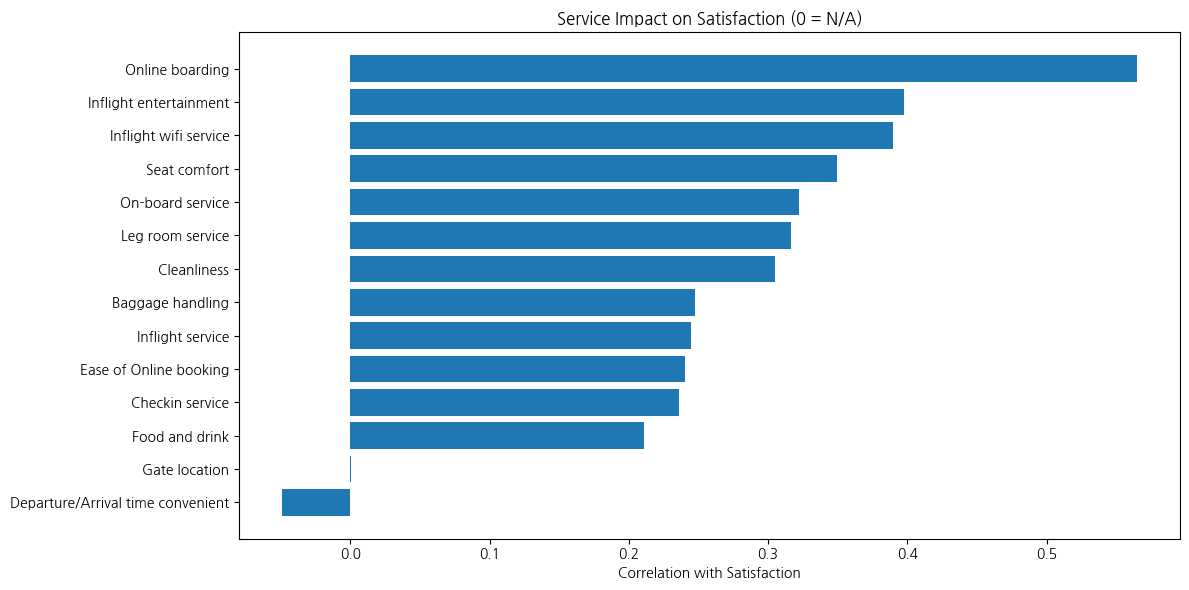

In [18]:
# 0을 결측치 처리하여 raw 데이터에 반영
for col in service_cols:
    train_raw[col] = train_raw[col].replace(0, np.nan)

# 상관계수 재계산
correlations = {}
for col in service_cols:
    corr = train_raw[[col, 'satisfaction_binary']].corr().iloc[0,1]
    correlations[col] = corr

# 정렬 및 출력
sorted_services = sorted(correlations.items(), key=lambda x: x[1], reverse=False)
print(f"{'Service':<40s} {'Correlation':>15s}")
print("-" * 55)
for service, corr in sorted_services:
    print(f"{service:<40s} {corr:>15.3f}")

# 시각화
services = [x[0] for x in sorted_services]
corrs = [x[1] for x in sorted_services]

plt.figure(figsize=(12, 6))
plt.barh(services, corrs)
plt.xlabel('Correlation with Satisfaction')
plt.title('Service Impact on Satisfaction (0 = N/A)')
plt.tight_layout()
plt.show()

## 다음 분석: 거리별 차이 확인
**핵심 질문:**
- "Online boarding은 모든 거리에서 1위인가?"
- "장거리에서는 Seat comfort나 Entertainment가 역전하는가?"
- "단거리에서는 디지털 서비스가, 장거리에서는 물리적 편안함이 더 중요한가?"

**주의할 점:**
"장거리에서는 Seat comfort나 Entertainment가 역전하는가?" 질문에서 단거리/중거리/장거리 Seat comfort는 클래스에 영향을 받기에 클래스 분포를 알아야한다.

In [19]:
# 거리별 그룹 분류
train_raw['distance_category'] = pd.cut(
    train_raw['Flight Distance'],
    bins=[0, 1000, 3000, 100000],
    labels=['Short (<1000km)', 'Medium (1000-3000km)', 'Long (>3000km)']
)

# 샘플 수 확인
print("거리별 샘플 수:")
print(train_raw['distance_category'].value_counts().sort_index())

# 거리별 클래스 분포 확인
distance_class_dist = pd.crosstab(
    train_raw['distance_category'], 
    train_raw['Class'], 
    normalize='index'
) * 100
print("\n=== 거리별 클래스 분포 (%) ===")
print(distance_class_dist)

# 클래스별 만족도 비율
print("\n=== 클래스별 만족도 (satisfied 비율 %) ===")
class_satisfaction = pd.crosstab(
    train_raw['Class'],
    train_raw['satisfaction'],
    normalize='index'
) * 100
print(class_satisfaction)


거리별 샘플 수:
distance_category
Short (<1000km)         60065
Medium (1000-3000km)    35574
Long (>3000km)           8265
Name: count, dtype: int64

=== 거리별 클래스 분포 (%) ===
Class                  Business        Eco  Eco Plus
distance_category                                   
Short (<1000km)       31.172896  59.279114  9.547990
Medium (1000-3000km)  63.914657  31.174453  4.910890
Long (>3000km)        99.261948   0.592861  0.145191

=== 클래스별 만족도 (satisfied 비율 %) ===
satisfaction  neutral or dissatisfied  satisfied
Class                                           
Business                    30.574852  69.425148
Eco                         81.386245  18.613755
Eco Plus                    75.393648  24.606352


In [20]:
# 거리별 & 클래스별 만족도 비율
print("\n=== 거리별 & 클래스별 만족도 (satisfied 비율 %) ===")
for distance in ['Short (<1000km)', 'Medium (1000-3000km)', 'Long (>3000km)']:
    print(f"\n{distance}:")
    print("-" * 60)
    
    data = train_raw[train_raw['distance_category'] == distance]
    
    dist_class_sat = pd.crosstab(
        data['Class'],
        data['satisfaction'],
        normalize='index'
    ) * 100
    
    print(dist_class_sat)


=== 거리별 & 클래스별 만족도 (satisfied 비율 %) ===

Short (<1000km):
------------------------------------------------------------
satisfaction  neutral or dissatisfied  satisfied
Class                                           
Business                    38.912626  61.087374
Eco                         80.730776  19.269224
Eco Plus                    73.966870  26.033130

Medium (1000-3000km):
------------------------------------------------------------
satisfaction  neutral or dissatisfied  satisfied
Class                                           
Business                    26.758148  73.241852
Eco                         83.462579  16.537421
Eco Plus                    80.080137  19.919863

Long (>3000km):
------------------------------------------------------------
satisfaction  neutral or dissatisfied  satisfied
Class                                           
Business                    22.123354  77.876646
Eco                         87.755102  12.244898
Eco Plus                    75.0

위 결과를 보면 

In [21]:
# 단거리 분석
print("=" * 60)
print("Short (<1000km)")
print("=" * 60)

data_short = train_raw[train_raw['distance_category'] == 'Short (<1000km)']

correlations_short = {}
for col in service_cols:
    corr = data_short[[col, 'satisfaction_binary']].corr().iloc[0,1]
    correlations_short[col] = corr

sorted_corr_short = sorted(correlations_short.items(), key=lambda x: x[1], reverse=True)

print(f"{'Rank':<5s} {'Service':<40s} {'Correlation':>15s}")
print("-" * 60)
for i, (service, corr) in enumerate(sorted_corr_short, 1):
    print(f"{i:<5d} {service:<40s} {corr:>15.3f}")

Short (<1000km)
Rank  Service                                      Correlation
------------------------------------------------------------
1     Online boarding                                    0.525
2     Inflight wifi service                              0.494
3     Inflight entertainment                             0.315
4     Ease of Online booking                             0.300
5     Seat comfort                                       0.252
6     On-board service                                   0.235
7     Cleanliness                                        0.229
8     Leg room service                                   0.228
9     Food and drink                                     0.170
10    Inflight service                                   0.159
11    Checkin service                                    0.156
12    Baggage handling                                   0.151
13    Gate location                                     -0.004
14    Departure/Arrival time convenient  

In [22]:
# 중거리 분석
print("=" * 60)
print("Medium (1000-3000km)")
print("=" * 60)

data_medium = train_raw[train_raw['distance_category'] == 'Medium (1000-3000km)']

correlations_medium = {}
for col in service_cols:
    corr = data_medium[[col, 'satisfaction_binary']].corr().iloc[0,1]
    correlations_medium[col] = corr

sorted_corr_medium = sorted(correlations_medium.items(), key=lambda x: x[1], reverse=True)

print(f"{'Rank':<5s} {'Service':<40s} {'Correlation':>15s}")
print("-" * 60)
for i, (service, corr) in enumerate(sorted_corr_medium, 1):
    print(f"{i:<5d} {service:<40s} {corr:>15.3f}")

Medium (1000-3000km)
Rank  Service                                      Correlation
------------------------------------------------------------
1     Online boarding                                    0.588
2     Inflight entertainment                             0.456
3     Seat comfort                                       0.425
4     On-board service                                   0.386
5     Leg room service                                   0.375
6     Cleanliness                                        0.371
7     Baggage handling                                   0.343
8     Inflight service                                   0.316
9     Inflight wifi service                              0.309
10    Checkin service                                    0.307
11    Food and drink                                     0.249
12    Ease of Online booking                             0.190
13    Gate location                                      0.004
14    Departure/Arrival time conveni

In [23]:
# 장거리 분석
print("=" * 60)
print("Long (>3000km)")
print("=" * 60)

data_long = train_raw[train_raw['distance_category'] == 'Long (>3000km)']

correlations_long = {}
for col in service_cols:
    corr = data_long[[col, 'satisfaction_binary']].corr().iloc[0,1]
    correlations_long[col] = corr

sorted_corr_long = sorted(correlations_long.items(), key=lambda x: x[1], reverse=True)

print(f"{'Rank':<5s} {'Service':<40s} {'Correlation':>15s}")
print("-" * 60)
for i, (service, corr) in enumerate(sorted_corr_long, 1):
    print(f"{i:<5d} {service:<40s} {corr:>15.3f}")

Long (>3000km)
Rank  Service                                      Correlation
------------------------------------------------------------
1     Inflight entertainment                             0.608
2     On-board service                                   0.531
3     Inflight service                                   0.517
4     Baggage handling                                   0.505
5     Leg room service                                   0.500
6     Online boarding                                    0.481
7     Seat comfort                                       0.477
8     Cleanliness                                        0.472
9     Checkin service                                    0.427
10    Food and drink                                     0.264
11    Inflight wifi service                              0.196
12    Departure/Arrival time convenient                  0.017
13    Ease of Online booking                             0.014
14    Gate location                       

**단거리 (<1000km): "빠르게, 효율적으로"**
- 1위: Online boarding (0.525) - 디지털 효율성
- 2위: Inflight wifi service (0.494) - 디지털 인프라
- 3위: Inflight entertainment (0.315)
- 4위: Ease of Online booking (0.300)
- 5위: Seat comfort (0.252)
- 13위: Gate location (-0.004)
- 14위: Departure/Arrival time convenient (-0.029)

**중거리 (1000-3000km): "균형"**
- 1위: Online boarding (0.588)
- 2위: Inflight entertainment (0.456)
- 3위: Seat comfort (0.425)
- 4위: On-board service (0.386)
- 9위: Inflight wifi service (0.309) - 중요도 하락
- 14위: Departure/Arrival time convenient (-0.046)

**장거리 (>3000km): "경험의 질"**
- 1위: Inflight entertainment (0.608) - 압도적
- 2위: On-board service (0.531)
- 3위: Inflight service (0.517)
- 4위: Baggage handling (0.505)
- 6위: Online boarding (0.481) - 대폭 하락
- 7위: Seat comfort (0.477) - 중거리보다 상관계수는 증가했지만 순위는 하락
- 11위: Inflight wifi service (0.196) - 2위→11위 몰락
- 13위: Ease of Online booking (0.014) - 거의 무의미

**요약**
1. 단거리: 디지털 독주
2. 중거리: Seat comfort가 3위로 급상승 (전환점)
3. 장거리: Seat comfort 상관계수는 더 올랐지만 (0.425→0.477), 다른 서비스들이 더 폭발적으로 상승해서 순위는 7위로 하락

In [24]:
# Business만 분석
print("=" * 80)
print("Business 클래스: 거리별 주요 서비스 상관계수")
print("=" * 80)

key_services = [
    'Online boarding',
    'Inflight entertainment',
    'Seat comfort',
    'On-board service',
    'Inflight wifi service'
]

business_results = {}

for service in key_services:
    business_results[service] = []
    
    print(f"\n{service}:")
    print("-" * 60)
    
    for distance in ['Short (<1000km)', 'Medium (1000-3000km)', 'Long (>3000km)']:
        data = train_raw[
            (train_raw['Class'] == 'Business') & 
            (train_raw['distance_category'] == distance)
        ]
        
        corr = data[[service, 'satisfaction_binary']].corr().iloc[0,1]
        business_results[service].append(corr)
        
        print(f"{distance:30s}: {corr:>7.3f} (n={len(data):>6,})")

# Eco 참고 (단거리 vs 중거리만)
print("\n\n" + "=" * 80)
print("Eco 클래스: 거리별 주요 서비스 상관계수 (참고)")
print("=" * 80)

for service in key_services:
    print(f"\n{service}:")
    print("-" * 60)
    
    for distance in ['Short (<1000km)', 'Medium (1000-3000km)']:
        data = train_raw[
            (train_raw['Class'] == 'Eco') & 
            (train_raw['distance_category'] == distance)
        ]
        
        corr = data[[service, 'satisfaction_binary']].corr().iloc[0,1]
        print(f"{distance:30s}: {corr:>7.3f} (n={len(data):>6,})")
    
    print(f"Long (>3000km):                샘플 부족 (n=49)")

Business 클래스: 거리별 주요 서비스 상관계수

Online boarding:
------------------------------------------------------------
Short (<1000km)               :   0.571 (n=18,724)
Medium (1000-3000km)          :   0.544 (n=22,737)
Long (>3000km)                :   0.479 (n= 8,204)

Inflight entertainment:
------------------------------------------------------------
Short (<1000km)               :   0.427 (n=18,724)
Medium (1000-3000km)          :   0.545 (n=22,737)
Long (>3000km)                :   0.610 (n= 8,204)

Seat comfort:
------------------------------------------------------------
Short (<1000km)               :   0.349 (n=18,724)
Medium (1000-3000km)          :   0.474 (n=22,737)
Long (>3000km)                :   0.478 (n= 8,204)

On-board service:
------------------------------------------------------------
Short (<1000km)               :   0.371 (n=18,724)
Medium (1000-3000km)          :   0.473 (n=22,737)
Long (>3000km)                :   0.537 (n= 8,204)

Inflight wifi service:
-------------

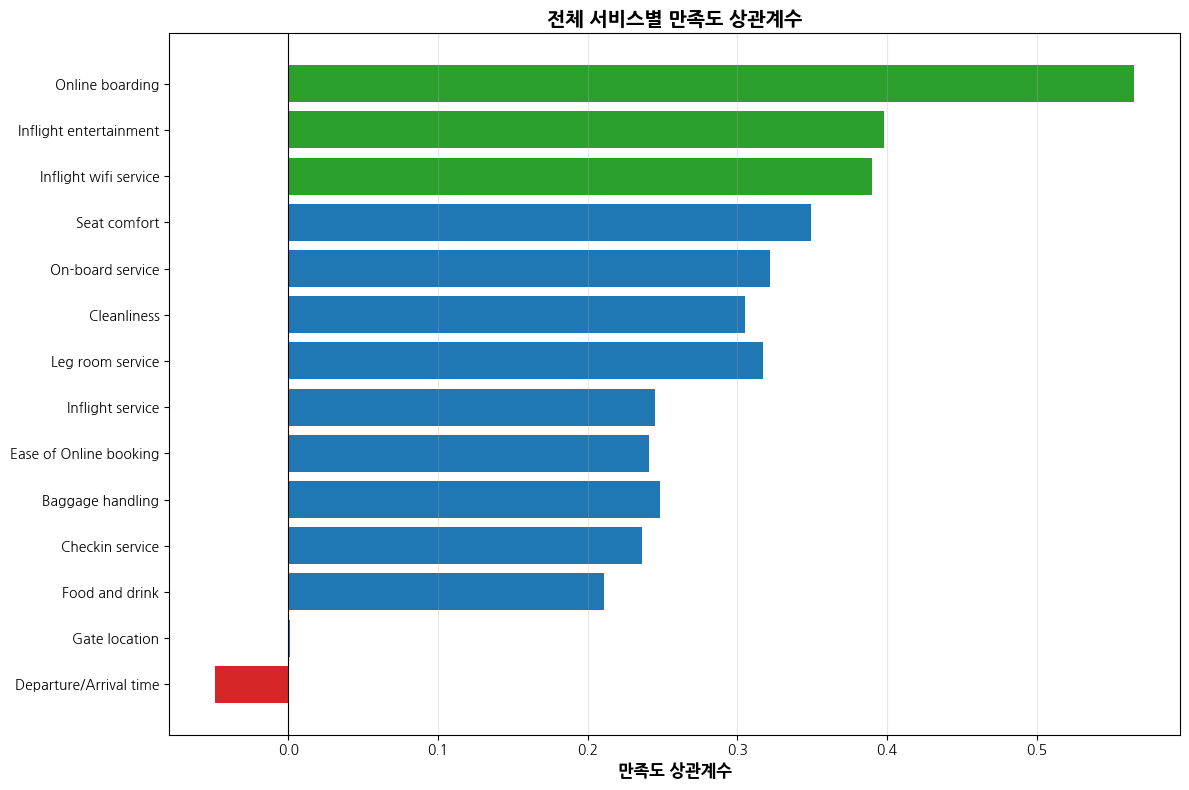

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows의 경우)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 1. 전체 서비스 상관계수 (수평 막대 그래프)
plt.figure(figsize=(12, 8))

services = [
    'Departure/Arrival time',
    'Gate location',
    'Food and drink',
    'Checkin service',
    'Baggage handling',
    'Ease of Online booking',
    'Inflight service',
    'Leg room service',
    'Cleanliness',
    'On-board service',
    'Seat comfort',
    'Inflight wifi service',
    'Inflight entertainment',
    'Online boarding'
]

correlations = [-0.049, 0.001, 0.211, 0.236, 0.248, 0.241, 0.245, 0.317, 
                0.305, 0.322, 0.349, 0.390, 0.398, 0.565]

colors = ['#d62728' if c < 0 else '#2ca02c' if i >= 11 else '#1f77b4' 
          for i, c in enumerate(correlations)]

plt.barh(services, correlations, color=colors)
plt.xlabel('만족도 상관계수', fontsize=12, fontweight='bold')
plt.title('전체 서비스별 만족도 상관계수', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('1_overall_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

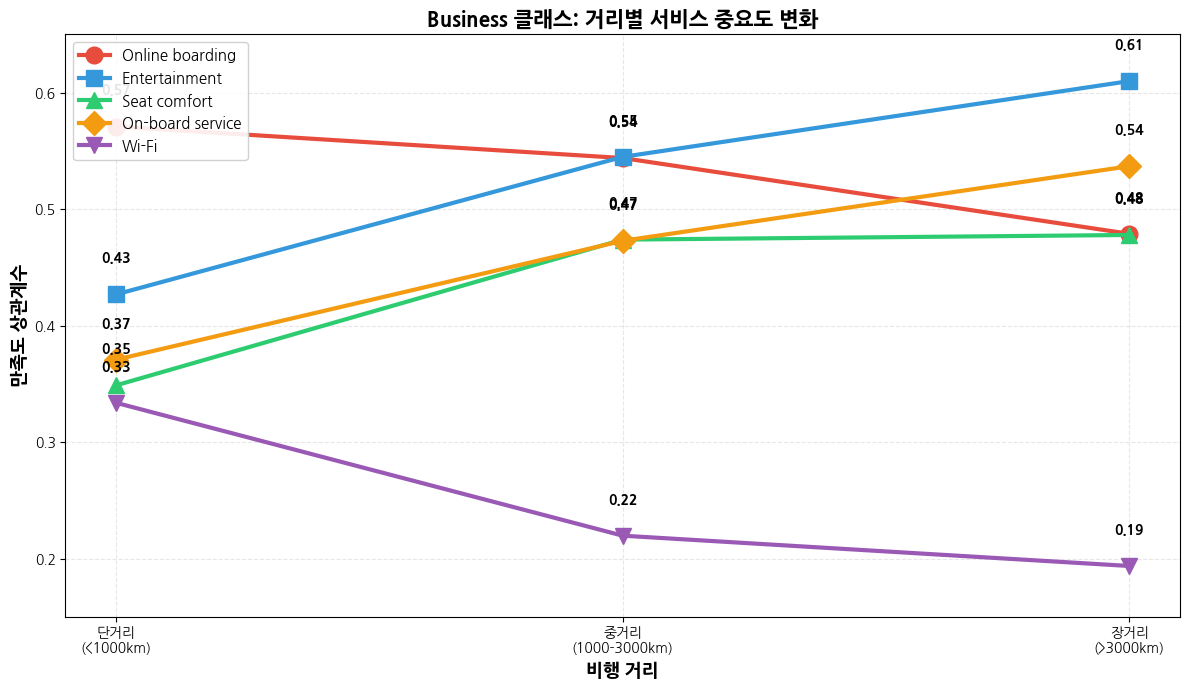

In [4]:
# 2. Business 클래스: 거리별 주요 서비스 변화 (선 그래프)
plt.figure(figsize=(12, 7))

distances = ['단거리\n(<1000km)', '중거리\n(1000-3000km)', '장거리\n(>3000km)']

business_data = {
    'Online boarding': [0.571, 0.544, 0.479],
    'Entertainment': [0.427, 0.545, 0.610],
    'Seat comfort': [0.349, 0.474, 0.478],
    'On-board service': [0.371, 0.473, 0.537],
    'Wi-Fi': [0.334, 0.220, 0.194]
}

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
markers = ['o', 's', '^', 'D', 'v']

for i, (service, values) in enumerate(business_data.items()):
    plt.plot(distances, values, 
             marker=markers[i], 
             linewidth=3, 
             markersize=12,
             label=service,
             color=colors[i])
    
    for j, val in enumerate(values):
        plt.text(j, val + 0.025, f'{val:.2f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('비행 거리', fontsize=13, fontweight='bold')
plt.ylabel('만족도 상관계수', fontsize=13, fontweight='bold')
plt.title('Business 클래스: 거리별 서비스 중요도 변화', fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0.15, 0.65)
plt.tight_layout()
plt.savefig('2_business_distance.png', dpi=300, bbox_inches='tight')
plt.show()

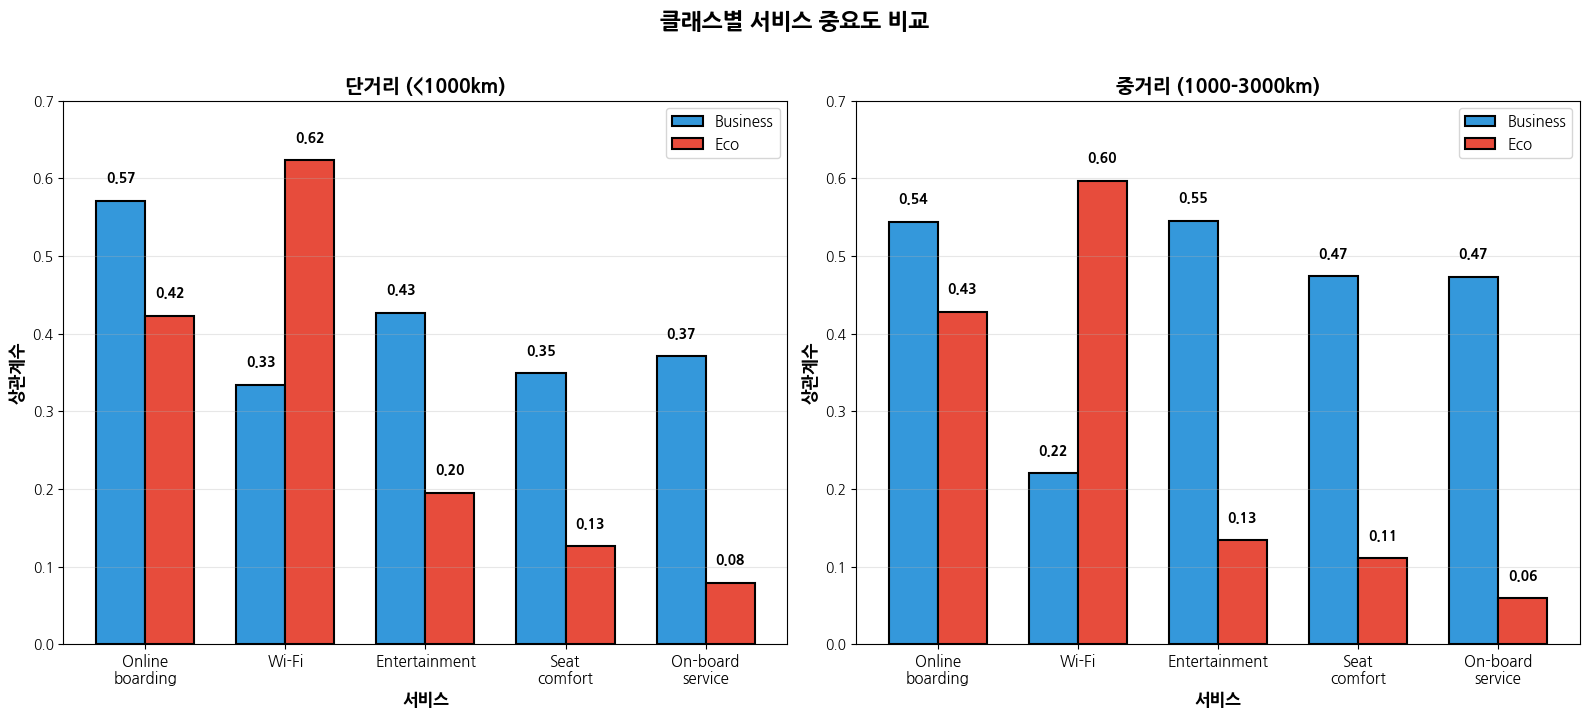

In [8]:
# 3. Eco vs Business 단거리 비교 (막대 그래프)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

services_short = ['Online\nboarding', 'Wi-Fi', 'Entertainment', 
                  'Seat\ncomfort', 'On-board\nservice']
business_short = [0.571, 0.334, 0.427, 0.349, 0.371]
eco_short = [0.423, 0.623, 0.195, 0.126, 0.079]

x = np.arange(len(services_short))
width = 0.35

bars1 = ax1.bar(x - width/2, business_short, width, 
                label='Business', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, eco_short, width, 
                label='Eco', color='#e74c3c', edgecolor='black', linewidth=1.5)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height+0.02,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_xlabel('서비스', fontsize=12, fontweight='bold')
ax1.set_ylabel('상관계수', fontsize=12, fontweight='bold')
ax1.set_title('단거리 (<1000km)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(services_short, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 0.7)

# 중거리
business_medium = [0.544, 0.220, 0.545, 0.474, 0.473]
eco_medium = [0.428, 0.597, 0.134, 0.111, 0.059]

bars3 = ax2.bar(x - width/2, business_medium, width, 
                label='Business', color='#3498db', edgecolor='black', linewidth=1.5)
bars4 = ax2.bar(x + width/2, eco_medium, width, 
                label='Eco', color='#e74c3c', edgecolor='black', linewidth=1.5)

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height+0.02,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_xlabel('서비스', fontsize=12, fontweight='bold')
ax2.set_ylabel('상관계수', fontsize=12, fontweight='bold')
ax2.set_title('중거리 (1000-3000km)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(services_short, fontsize=11)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 0.7)

plt.suptitle('클래스별 서비스 중요도 비교', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('3_class_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

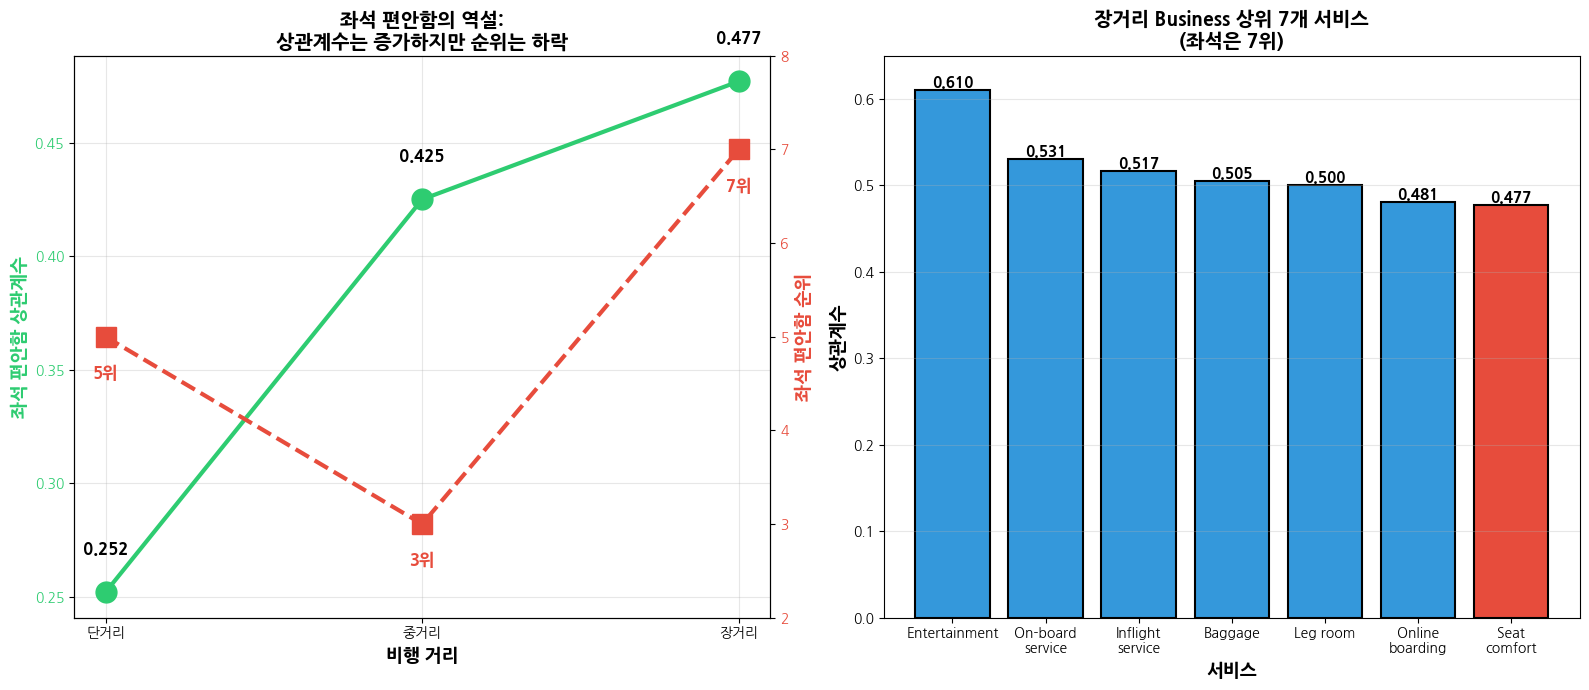

In [9]:
# 4. 좌석 편안함의 역설 (선 그래프 + 막대 그래프)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# 좌석 상관계수 변화
distances_kr = ['단거리', '중거리', '장거리']
seat_corr = [0.252, 0.425, 0.477]
seat_rank = [5, 3, 7]

color = '#2ecc71'
ax1.plot(distances_kr, seat_corr, marker='o', linewidth=3, 
         markersize=15, color=color, label='상관계수')
ax1.set_xlabel('비행 거리', fontsize=13, fontweight='bold')
ax1.set_ylabel('좌석 편안함 상관계수', fontsize=13, fontweight='bold', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

for i, (d, v) in enumerate(zip(distances_kr, seat_corr)):
    ax1.text(i, v + 0.015, f'{v:.3f}', 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1_right = ax1.twinx()
color2 = '#e74c3c'
ax1_right.plot(distances_kr, seat_rank, marker='s', linewidth=3, 
               markersize=15, color=color2, linestyle='--', label='순위')
ax1_right.set_ylabel('좌석 편안함 순위', fontsize=13, fontweight='bold', color=color2)
ax1_right.tick_params(axis='y', labelcolor=color2)
ax1_right.set_ylim(8, 2)
ax1_right.invert_yaxis()

for i, (d, v) in enumerate(zip(distances_kr, seat_rank)):
    ax1_right.text(i, v - 0.3, f'{v}위', 
                  ha='center', va='top', fontsize=12, fontweight='bold', color=color2)

ax1.set_title('좌석 편안함의 역설:\n상관계수는 증가하지만 순위는 하락', 
             fontsize=14, fontweight='bold')

# 장거리 Business Top 7
ax2_services = ['Entertainment', 'On-board\nservice', 'Inflight\nservice', 
                'Baggage', 'Leg room', 'Online\nboarding', 'Seat\ncomfort']
ax2_values = [0.610, 0.531, 0.517, 0.505, 0.500, 0.481, 0.477]
colors_bar = ['#e74c3c' if i == 6 else '#3498db' for i in range(7)]

bars = ax2.bar(ax2_services, ax2_values, color=colors_bar, 
               edgecolor='black', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_xlabel('서비스', fontsize=13, fontweight='bold')
ax2.set_ylabel('상관계수', fontsize=13, fontweight='bold')
ax2.set_title('장거리 Business 상위 7개 서비스\n(좌석은 7위)', 
             fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 0.65)

plt.tight_layout()
plt.savefig('4_seat_paradox.png', dpi=300, bbox_inches='tight')
plt.show()

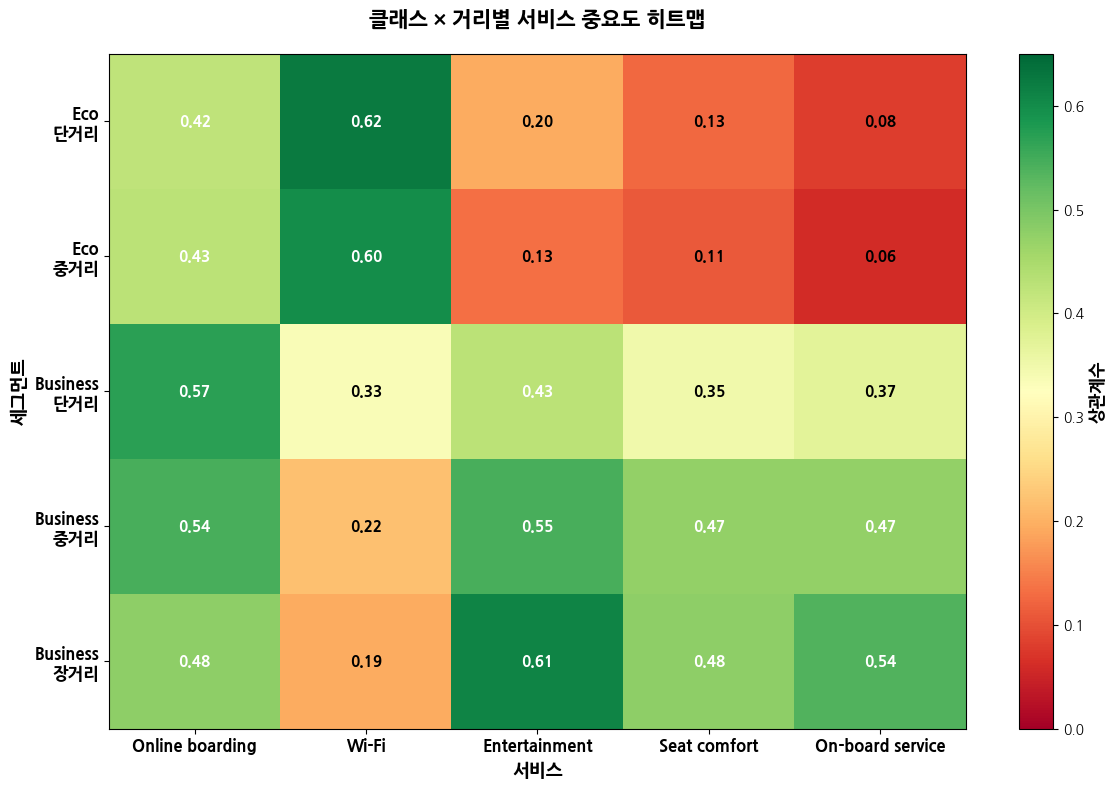

In [10]:
# 5. 클래스별 만족도 전략 요약 (히트맵)
fig, ax = plt.subplots(figsize=(12, 8))

strategies = ['Online boarding', 'Wi-Fi', 'Entertainment', 
              'Seat comfort', 'On-board service']
segments = ['Eco\n단거리', 'Eco\n중거리', 'Business\n단거리', 
            'Business\n중거리', 'Business\n장거리']

# 상관계수 데이터
data = np.array([
    [0.423, 0.623, 0.195, 0.126, 0.079],  # Eco 단거리
    [0.428, 0.597, 0.134, 0.111, 0.059],  # Eco 중거리
    [0.571, 0.334, 0.427, 0.349, 0.371],  # Business 단거리
    [0.544, 0.220, 0.545, 0.474, 0.473],  # Business 중거리
    [0.479, 0.194, 0.610, 0.478, 0.537],  # Business 장거리
])

im = ax.imshow(data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=0.65)

ax.set_xticks(np.arange(len(strategies)))
ax.set_yticks(np.arange(len(segments)))
ax.set_xticklabels(strategies, fontsize=12, fontweight='bold')
ax.set_yticklabels(segments, fontsize=12, fontweight='bold')

# 값 표시
for i in range(len(segments)):
    for j in range(len(strategies)):
        text = ax.text(j, i, f'{data[i, j]:.2f}',
                      ha="center", va="center", 
                      color="black" if data[i, j] < 0.4 else "white",
                      fontsize=11, fontweight='bold')

ax.set_title('클래스 × 거리별 서비스 중요도 히트맵', 
            fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel('서비스', fontsize=13, fontweight='bold')
ax.set_ylabel('세그먼트', fontsize=13, fontweight='bold')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('상관계수', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('5_strategy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()